In [170]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [171]:
# Load and preprocess data
def Normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # Avoid division by zero for features with no variance
    std[std == 0] = 1

    X_normalized = (X - mean) / std
    return X_normalized                      # TODO: Implement the normalization function


def load_data():
    url_hospital = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
    data = pd.read_csv(
        url_hospital,
        header=None,
        names=["age", "year", "nodes_detected", "survival_status"],
    )
    X = data.iloc[:, :3].to_numpy()
    y = (data.iloc[:, 3] == 1).astype(int)  # Convert survival status to binary
    X = Normalize(X)

    return X, y

In [172]:
# Logistic function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))                       # TODO: Implement the sigmoid function

# Negative Log-Likelihood
def nll(beta, X, y):
    logits = X @ beta
    probabilities = sigmoid(logits)
    # To avoid log(0), clip probabilities to a small positive value
    probabilities = np.clip(probabilities, 1e-10, 1 - 1e-10)
    return -np.sum(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities)) # TODO: Implement NLL function


# Gradient of NLL
def gradient(beta, X, y):
    probabilities = sigmoid(X @ beta)
    return X.T @ (probabilities - y)     # TODO: Implement the gradient of NLL


# Hessian of NLL
def hessian(beta, X):
    probabilities = sigmoid(X @ beta)
    W = np.diag((probabilities * (1 - probabilities)).flatten())
    return X.T @ W @ X       # TODO: Implement the hessian of NLL

In [173]:
# Newton-Raphson optimization
def newton_raphson(X, y, tol=1e-6, max_iter=100):
    beta = np.zeros(X.shape[1])    # TODO: Implement the Newton-Raphson optimization
    for iteration in range(max_iter):
        grad = gradient(beta, X, y)
        hess = hessian(beta, X)

        # Add small constant to the diagonal of Hessian for numerical stability
        hess += np.eye(hess.shape[0]) * 1e-6

        beta_update = np.linalg.inv(hess) @ grad
        beta -= beta_update

        if np.linalg.norm(beta_update) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break
    else:
        print("Reached maximum iterations without convergence.")

    return beta

In [174]:
def predict(X, beta):
    probabilities = sigmoid(X @ beta)
    # Convert probabilities to binary predictions
    return (probabilities >= 0.5).astype(int)    # TODO: Implement the prediction function

In [175]:
# Main workflow

# Load and preprocess data
X, y = load_data()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train logistic regression model
beta = newton_raphson(X_train, y_train)

# Predictions and evaluation metrics for Newton Raphson
NP_preds = predict(X_test, beta)
NP_accuracy = accuracy_score(y_test, NP_preds)
NP_precision = precision_score(y_test, NP_preds)
NP_recall = recall_score(y_test, NP_preds)
NP_f1 = f1_score(y_test, NP_preds)

# Print metrics
print(f"Newton Raphson Accuracy: {NP_accuracy:.2f}")
print(f"Newton Raphson Precision: {NP_precision:.2f}")
print(f"Newton Raphson Recall: {NP_recall:.2f}")
print(f"Newton Raphson F1 Score: {NP_f1:.2f}")



Converged after 5 iterations.
Newton Raphson Accuracy: 0.66
Newton Raphson Precision: 0.76
Newton Raphson Recall: 0.77
Newton Raphson F1 Score: 0.76


In [176]:
# Train logistic regression model using sklearn
logreg = LogisticRegression(fit_intercept=True, solver="lbfgs")
logreg.fit(X_train, y_train)

# Predictions and evaluation metrics for Scikit Learn
SC_preds = logreg.predict(X_test)
SC_accuracy = accuracy_score(y_test, SC_preds)
SC_precision = precision_score(y_test, SC_preds)
SC_recall = recall_score(y_test, SC_preds)
SC_f1 = f1_score(y_test, SC_preds)
# Print metrics
print(f"Scikit Learn Accuracy: {SC_accuracy:.2f}")
print(f"Scikit Learn Precision: {SC_precision:.2f}")
print(f"Scikit Learn Recall: {SC_recall:.2f}")
print(f"Scikit Learn F1 Score: {SC_f1:.2f}")

Scikit Learn Accuracy: 0.69
Scikit Learn Precision: 0.73
Scikit Learn Recall: 0.91
Scikit Learn F1 Score: 0.81


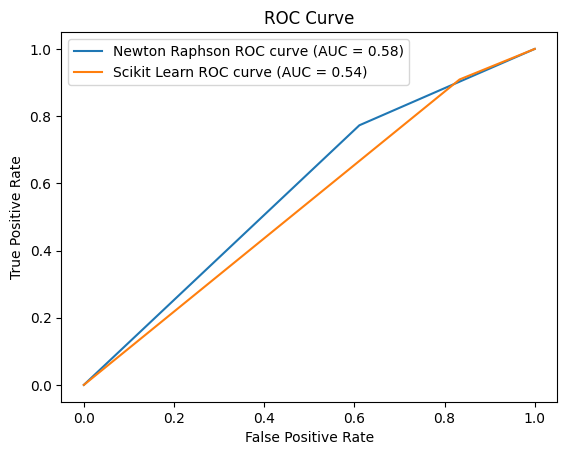

In [177]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, NP_preds)
fpr2, tpr2, _ = roc_curve(y_test, SC_preds)
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr, tpr, label=f"Newton Raphson ROC curve (AUC = {roc_auc:.2f})")
plt.plot(fpr2, tpr2, label=f"Scikit Learn ROC curve (AUC = {roc_auc2:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [178]:
lambda_reg=1.0

# Gradient of the negative log-posterior
def grad_neg_log_posterior(beta, X, y):
    # Compute probabilities using sigmoid
    logits = X @ beta
    probabilities = 1 / (1 + np.exp(-logits))

    # Compute gradient of NLL
    grad_nll = X.T @ (probabilities - y)

    # Add regularization term
    return grad_nll + lambda_reg * beta    #TODO: Implement the gradient of Negative log-posterior


# Hessian of the negative log-posterior
def hessian_neg_log_posterior(beta, X):
    # Compute probabilities using sigmoid
    logits = X @ beta
    probabilities = 1 / (1 + np.exp(-logits))

    # Compute W (diagonal matrix of weights)
    W = np.diag((probabilities * (1 - probabilities)).flatten())

    # Compute Hessian of NLL
    hess_nll = X.T @ W @ X

    # Add regularization term
    return hess_nll + lambda_reg * np.eye(X.shape[1])       # TODO: Implement the hessian of Negative log-posterior

In [179]:
hessian = hessian_neg_log_posterior
gradient = grad_neg_log_posterior

# Train logistic regression model for Laplace approximation
LA_beta = newton_raphson(X_train, y_train)

# Predictions and evaluation metrics for Newton Raphson
LA_preds = predict(X_test, LA_beta)
LA_accuracy = accuracy_score(y_test, LA_preds)
LA_precision = precision_score(y_test, LA_preds)
LA_recall = recall_score(y_test, LA_preds)
LA_f1 = f1_score(y_test, LA_preds)

# Print metrics
print(f"Laplace approximation Accuracy: {LA_accuracy:.2f}")
print(f"Laplace approximation Precision: {LA_precision:.2f}")
print(f"Laplace approximation Recall: {LA_recall:.2f}")
print(f"Laplace approximation F1 Score: {LA_f1:.2f}")

Converged after 5 iterations.
Laplace approximation Accuracy: 0.66
Laplace approximation Precision: 0.76
Laplace approximation Recall: 0.77
Laplace approximation F1 Score: 0.76


# _**Q4 - Optional Exercise**_

In [180]:
# L2 Regularized Gradient
def gradient_reg(beta, X, y, lambda_reg=1.0):
    probabilities = sigmoid(X @ beta)
    grad_nll = X.T @ (probabilities - y)

    regularization = np.hstack(([0], lambda_reg * beta[1:]))
    return grad_nll + regularization

# L2 Regularized Hessian
def hessian_reg(beta, X, lambda_reg=1.0):
    probabilities = sigmoid(X @ beta)
    W = np.diag((probabilities * (1 - probabilities)).flatten())
    hess_nll = X.T @ W @ X

    regularization = np.eye(X.shape[1])
    regularization[0, 0] = 0
    return hess_nll + lambda_reg * regularization

In [181]:
def newton_raphson_reg(X, y, lambda_reg=1.0, tol=1e-6, max_iter=100):
    beta = np.zeros(X.shape[1])
    for iteration in range(max_iter):

        grad = gradient_reg(beta, X, y, lambda_reg)
        hess = hessian_reg(beta, X, lambda_reg)

        # Add small constant to the diagonal of Hessian for numerical stability
        hess += np.eye(hess.shape[0]) * 1e-6

        beta_update = np.linalg.inv(hess) @ grad
        beta -= beta_update

        if np.linalg.norm(beta_update) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break
    else:
        print("Reached maximum iterations without convergence.")

    return beta


In [182]:
# Train logistic regression models
lambda_reg = 100.0
beta_unreg = newton_raphson(X_train, y_train)
beta_reg = newton_raphson_reg(X_train, y_train, lambda_reg)

preds_unreg = predict(X_test, beta_unreg)
preds_reg = predict(X_test, beta_reg)

# Metrics for unregularized model
unreg_accuracy = accuracy_score(y_test, preds_unreg)
unreg_precision = precision_score(y_test, preds_unreg)
unreg_recall = recall_score(y_test, preds_unreg)
unreg_f1 = f1_score(y_test, preds_unreg)

print("Unregularized Logistic Regression:")
print(f"Accuracy: {unreg_accuracy:.2f}")
print(f"Precision: {unreg_precision:.2f}")
print(f"Recall: {unreg_recall:.2f}")
print(f"F1 Score: {unreg_f1:.2f}")

# Metrics for regularized model
reg_accuracy = accuracy_score(y_test, preds_reg)
reg_precision = precision_score(y_test, preds_reg)
reg_recall = recall_score(y_test, preds_reg)
reg_f1 = f1_score(y_test, preds_reg)

print("\nRegularized Logistic Regression:")
print(f"Accuracy: {reg_accuracy:.2f}")
print(f"Precision: {reg_precision:.2f}")
print(f"Recall: {reg_recall:.2f}")
print(f"F1 Score: {reg_f1:.2f}")

print(beta_unreg)
print(beta_reg)


Converged after 4 iterations.
Converged after 4 iterations.
Unregularized Logistic Regression:
Accuracy: 0.63
Precision: 0.74
Recall: 0.73
F1 Score: 0.74

Regularized Logistic Regression:
Accuracy: 0.56
Precision: 0.73
Recall: 0.61
F1 Score: 0.67
[-0.07973279  0.02708206 -0.21549489]
[-0.21481862  0.0323423  -0.21870906]


Converged after 4 iterations.
Converged after 4 iterations.


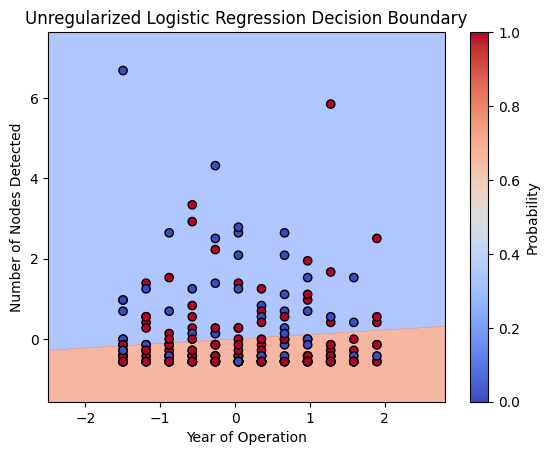

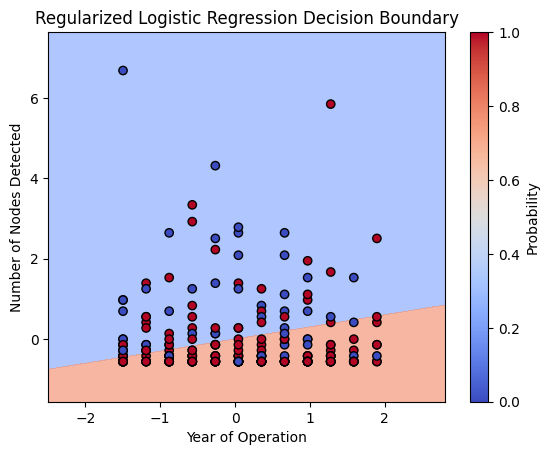

In [183]:
# Feature 1: Year, Feature 2: Nodes Detected
X_train_2d = X_train[:, [1, 2]]
X_test_2d = X_test[:, [1, 2]]

beta_unreg_2d = newton_raphson(X_train_2d, y_train)
beta_reg_2d = newton_raphson_reg(X_train_2d, y_train, lambda_reg)

x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

grid = np.c_[xx.ravel(), yy.ravel()]

probs_unreg = sigmoid(grid @ beta_unreg_2d).reshape(xx.shape)
probs_reg = sigmoid(grid @ beta_reg_2d).reshape(xx.shape)

# Plot the decision boundary for the unregularized model
plt.contourf(xx, yy, probs_unreg, levels=[0, 0.5, 1], alpha=0.7, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolor="k", cmap=plt.cm.coolwarm)
plt.title("Unregularized Logistic Regression Decision Boundary")
plt.xlabel("Year of Operation")
plt.ylabel("Number of Nodes Detected")
plt.colorbar(label="Probability")
plt.show()

# Plot the decision boundary for the regularized model
plt.contourf(xx, yy, probs_reg, levels=[0, 0.5, 1], alpha=0.7, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolor="k", cmap=plt.cm.coolwarm)
plt.title("Regularized Logistic Regression Decision Boundary")
plt.xlabel("Year of Operation")
plt.ylabel("Number of Nodes Detected")
plt.colorbar(label="Probability")
plt.show()
